## Encoder-Decoder NMT Network (without attention)

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
from keras import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Embedding
from keras.models import Model
from keras.initializers import Constant

MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

print('Indexing word vectors.')

embeddings_index = {}
with open('data/glove/glove.6B.300d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f'Found {len(embeddings_index)} word vectors.')

Using TensorFlow backend.


Indexing word vectors.
Found 400000 word vectors.


## Data import

In [3]:
from preprocessing import load_nlen_pairs

en, nl = load_nlen_pairs()

In [4]:
print(f"EN input shape: {en['data'].shape}")
print(f"NL target shape: {nl['data'].shape}")

EN input shape: (1997775, 100)
NL target shape: (1997775, 100)


In [5]:
for a, b in zip(en['text'][:5], nl['text'][:5]):
    print(a, "\n---\n", b,"\n")

Resumption of the session 
---
 Hervatting van de zitting 

I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999, and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period. 
---
 Ik verklaar de zitting van het Europees Parlement, die op vrijdag 17 december werd onderbroken, te zijn hervat. Ik wens u allen een gelukkig nieuwjaar en hoop dat u een goede vakantie heeft gehad. 

Although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disasters that truly were dreadful. 
---
 Zoals u heeft kunnen constateren, is de grote "millenniumbug" uitgebleven. De burgers van een aantal van onze lidstaten zijn daarentegen door verschrikkelijke natuurrampen getroffen. 

You have requested a debate on this subject in the course of the next few days, during this part-session. 
---
 U heeft aangegeven dat u deze ve

In [6]:
num_words = len(en['vocab']) + 1
embedding_matrix = np.zeros((num_words, 300))
for word, i in en['vocab'].items():
    if i > 10_000:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [7]:
print(f"Embedding matrix has shape: f{embedding_matrix.shape}")

embedding_layer = Embedding(num_words,
                            300,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=100,
                            trainable=False)

Embedding matrix has shape: f(118497, 300)


## Testing Embedding Layer

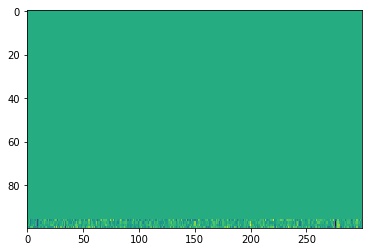

In [8]:
from matplotlib.pyplot import imshow

test_model = Sequential()
test_model.add(embedding_layer)
test_emb = test_model.predict(en['data'][:100])

imshow(test_emb[0], aspect='auto')

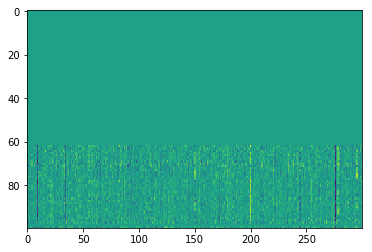

In [9]:
imshow(test_emb[1], aspect='auto')

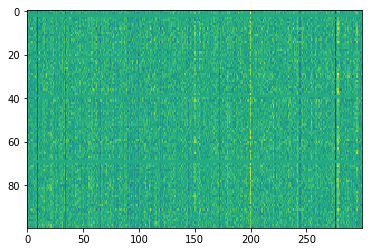

In [10]:
imshow(test_emb[80], aspect='auto')

## Defining Network

In [65]:
from keras.layers import LSTM, RepeatVector
from keras.optimizers import SGD
from layers import sparse_cross_entropy
import tensorflow as tf

model = Sequential()
model.add(embedding_layer)
model.add(LSTM(
    units=124,
    return_sequences=True
))
# model.add(RepeatVector(100))
model.add(LSTM(
    units=124,
    return_sequences=True
))
model.add(Dense(np.max(nl['data']) + 1, activation="linear"))

decoder_target = tf.placeholder(dtype='int32', shape=(None, None))

model.compile(loss=sparse_cross_entropy, 
              optimizer='adam', 
              metrics=['acc'],
              target_tensors=[decoder_target])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          35549100  
_________________________________________________________________
lstm_37 (LSTM)               (None, 100, 124)          210800    
_________________________________________________________________
lstm_38 (LSTM)               (None, 100, 124)          123504    
_________________________________________________________________
dense_17 (Dense)             (None, 100, 20000)        2500000   
Total params: 38,383,404
Trainable params: 2,834,304
Non-trainable params: 35,549,100
_________________________________________________________________


In [66]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(en['data'], nl['data'], random_state=5)

print(f"NN input shape: {model.layers[0].input_shape}")
print(f"NN output shape: {model.layers[-1].output_shape}")
print(f"train shape: {X_train.shape}")
print(f"test shape: {y_train.shape}")

NN input shape: (None, 100)
NN output shape: (None, 100, 20000)
train shape: (1498331, 100)
test shape: (1498331, 100)


In [67]:
model.layers[0].input_shape

(None, 100)

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
filepath = "model/lstm-seqdec-{epoch:02d}-{val_acc:.2f}.hdf5"
cp_cb = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

cp_tb = TensorBoard(log_dir="logs")

model.fit(X_train, y_train,
          batch_size=1024,
          epochs=10,
          callbacks=[cp_cb, cp_tb],
          validation_data=(X_test, y_test))

Train on 1498331 samples, validate on 499444 samples
Epoch 1/10


## Evaluate

In [96]:
pred_test_en = model.predict(test_en_data[:10])

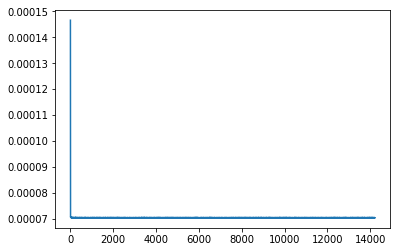

In [97]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

plt.plot(pred_test_en[6][0])

In [98]:
imshow(pred_test_en[], aspect='auto')

SyntaxError: invalid syntax (<ipython-input-98-1d4c8e59b34d>, line 1)

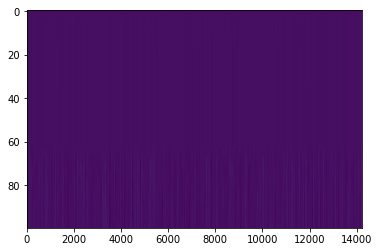

In [99]:
imshow(pred_test_en[1], aspect='auto')

In [100]:
pred_test_en[3].shape

(100, 14212)

In [83]:
print(pred_test_en[0][0])

[1.54607667e-04 1.25618331e-04 1.20392106e-04 ... 6.69126384e-05
 6.70071822e-05 6.70216104e-05]


In [84]:
pred_idx = np.argmax(pred_test_en,axis=2)

In [85]:
inv_vocab_nl = {v: k for k, v in nl_vocab.items()}